<a href="https://colab.research.google.com/github/mayafeldthouse/Microscopy_decon/blob/main/least_squares_for_OTF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install napari

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59

In [32]:
!pip install imagecodecs

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#to check the pathing of your Google Drive folders and make sure all your stuff is in there
!ls "/content/drive/MyDrive/Rawfiles/Parameter Tuning/OTF Threshold/"

groundtruth  test_deconv


Initialization:

Ground Truth Files:
- er: True (/content/drive/My Drive/Rawfiles/Parameter Tuning/OTF Threshold/groundtruth/er_gt_px_108nm.tif)
- mito: True (/content/drive/My Drive/Rawfiles/Parameter Tuning/OTF Threshold/groundtruth/mito_gt_px_108nm.tif)

OMW Folders Found: 5
- matlab_decon_omw_thres_0.5
- matlab_decon_omw_thres_0.75
- matlab_decon_omw_thres_0.88
- matlab_decon_omw_thres_0.98
- matlab_decon_omw_thres_0.99

Starting analysis...
Memory usage: 587.35 MB

Processing folder: matlab_decon_omw_thres_0.5
Memory usage: 587.35 MB

Analyzing: CamB_ch0_er_simulated_raw_Confocal_1AU_px_108nm_0lambda_snr_16.tif
Parameters: {'channel': 'er', 'snr': 16, 'OMW': 0.5}
Memory usage: 613.07 MB

Processing folder: matlab_decon_omw_thres_0.75
Memory usage: 613.07 MB

Analyzing: CamB_ch0_er_simulated_raw_Confocal_1AU_px_108nm_0lambda_snr_16.tif
Parameters: {'channel': 'er', 'snr': 16, 'OMW': 0.75}
Memory usage: 632.90 MB

Processing folder: matlab_decon_omw_thres_0.88
Memory usage: 632.90 M

ValueError: attempt to get argmin of an empty sequence

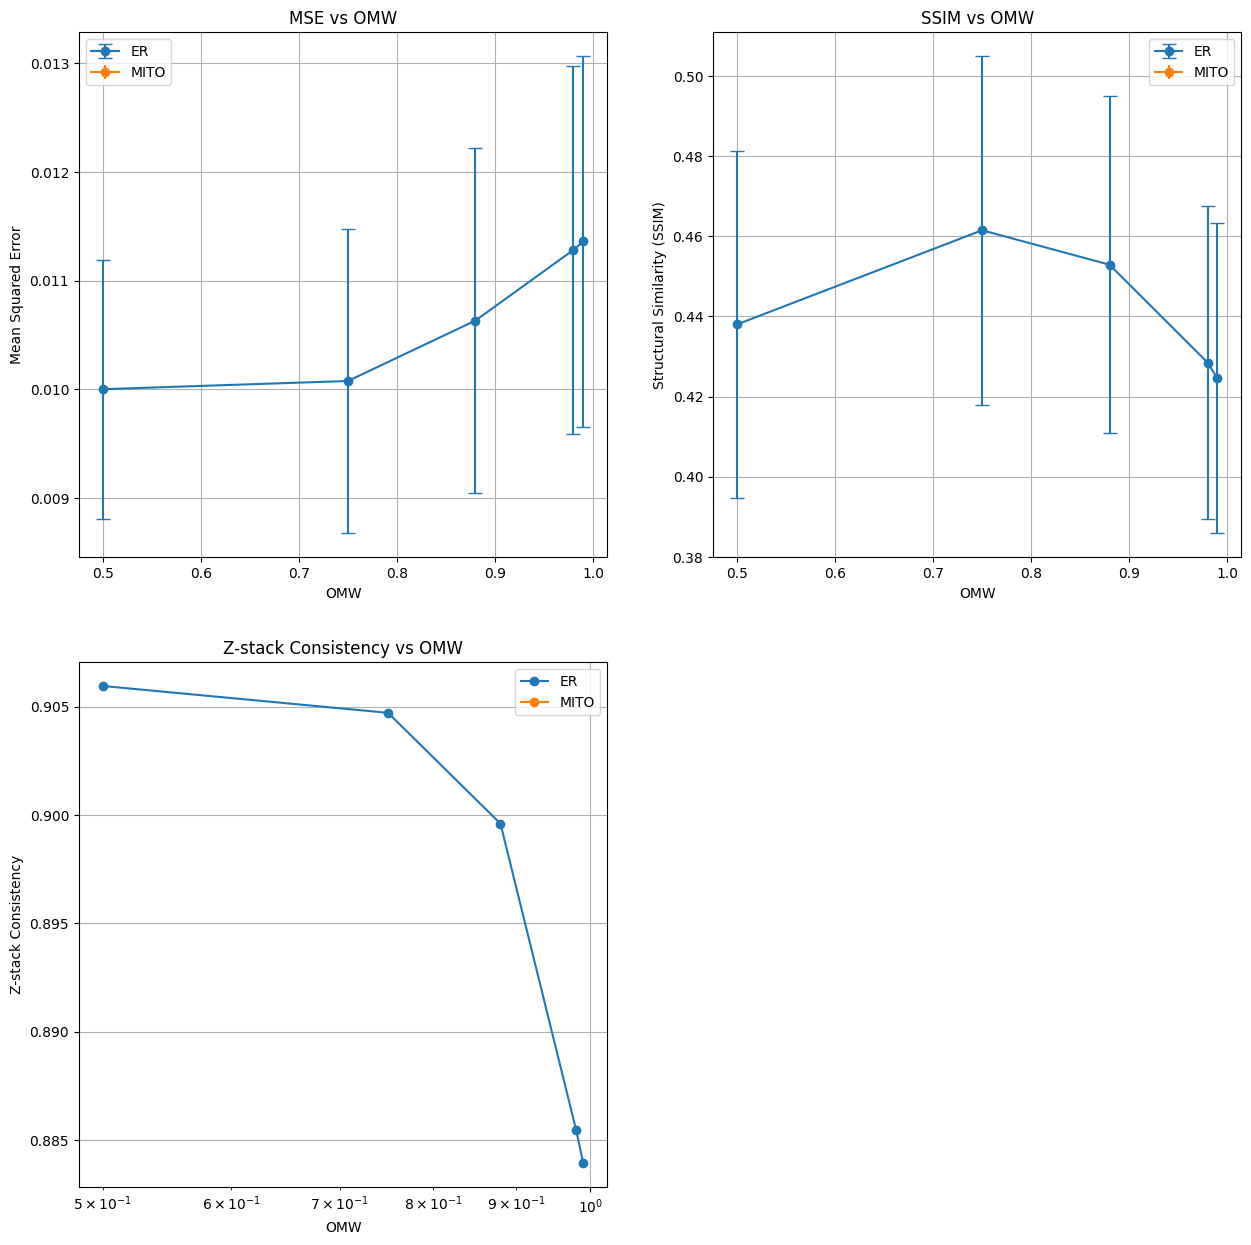

In [9]:
import napari
import numpy as np
from pathlib import Path
import imagecodecs
import tifffile
import re
import pandas as pd
from skimage import metrics
import gc
import psutil
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

def clear_memory():
    """
    Utility function to clear memory and report usage.
    Critical for handling large microscopy datasets efficiently.
    """
    plt.close('all')  # Close any open matplotlib figures
    gc.collect()      # Force garbage collection
    print(f"Memory usage: {psutil.Process().memory_info().rss / 1024 / 1024:.2f} MB")

class DeconvolutionAnalyzer:
    """
    Analyzes deconvolved microscopy images against ground truth data.
    Handles multiple OMW parameters and compares quality across z-stacks.
    """
    def __init__(self):
        # Set up file paths

        ##for getting data from our google doc, make sure you change the last item to rawdata_"your modality"

        ######################################################################
        ########Change file path name here####################################
        ######################################################################

        self.base_path = Path("/content/drive/My Drive/Rawfiles/Parameter Tuning/OTF Threshold")
        self.test_path = self.base_path / "test_deconv"
        self.viewer = None

        # Ground truth reference images
        self.gt_files = {
            'er': self.base_path / 'groundtruth/er_gt_px_108nm.tif',
            'mito': self.base_path / 'groundtruth/mito_gt_px_108nm.tif'
        }

        # Parameters for chunked processing
        self.chunk_size = 10  # Number of z-slices to process at once

        print("Initialization:")
        self._verify_files()

    def _verify_files(self):
        """Check existence of required files and report directory structure."""
        print("\nGround Truth Files:")
        for channel, path in self.gt_files.items():
            print(f"- {channel}: {path.exists()} ({path})")

        OMW_folders = list(self.test_path.glob("*omw_thres*"))
        print(f"\nOMW Folders Found: {len(OMW_folders)}")
        for folder in OMW_folders:
            print(f"- {folder.name}")

    def extract_parameters(self, filename: str, folder_path: str = None) -> dict:
        """
        Extract metadata from filename and folder structure.

        Parameters:
        -----------
        filename : str
            Name of deconvolved image file
        folder_path : str, optional
            Path containing OMW parameter

        Returns:
        --------
        dict with channel, SNR, and OMW parameters
        """
        params = {}

        # Extract channel type
        if 'er' in filename.lower():
            params['channel'] = 'er'
        elif 'mito' in filename.lower():
            params['channel'] = 'mito'

        # Extract SNR value
        snr_match = re.search(r'snr_(\d+)', filename)
        if snr_match:
            params['snr'] = int(snr_match.group(1))

        # Extract OTF from folder name
        if folder_path:
            OMW_match = re.search(r'omw_thres_([\d.]+)', str(folder_path))
            if OMW_match:
                params['OMW'] = float(OMW_match.group(1))

        return params

    def process_z_stack(self, gt: np.ndarray, deconv: np.ndarray) -> Dict:
        """
        Process and compare a pair of z-stacks.

        Parameters:
        -----------
        gt : np.ndarray
            Ground truth z-stack
        deconv : np.ndarray
            Deconvolved z-stack to compare

        Returns:
        --------
        Dict containing spatial and temporal metrics
        """
        # Match dimensions
        min_z = min(gt.shape[0], deconv.shape[0])
        min_y = min(gt.shape[1], deconv.shape[1])
        min_x = min(gt.shape[2], deconv.shape[2])

        # Crop to matching size
        gt = gt[:min_z, :min_y, :min_x]
        deconv = deconv[:min_z, :min_y, :min_x]

        # Normalize both images to [0,1] range
        gt_norm = (gt - gt.min()) / (gt.max() - gt.min())
        deconv_norm = (deconv - deconv.min()) / (deconv.max() - deconv.min())

        metrics_dict = {
            'mse_values': [],
            'ssim_values': [],
            'z_consistency': []
        }

        # Calculate per-slice metrics
        for z in range(min_z):
            mse = metrics.mean_squared_error(gt_norm[z], deconv_norm[z])
            ssim = metrics.structural_similarity(
                gt_norm[z],
                deconv_norm[z],
                data_range=1.0
            )
            metrics_dict['mse_values'].append(mse)
            metrics_dict['ssim_values'].append(ssim)

        # Calculate temporal consistency between adjacent z-slices
        for z in range(min_z - 1):
            consistency = metrics.structural_similarity(
                deconv_norm[z],
                deconv_norm[z + 1],
                data_range=1.0
            )
            metrics_dict['z_consistency'].append(consistency)

        return metrics_dict

    def analyze_files(self):
        """Main analysis pipeline."""
        try:
            print("\nStarting analysis...")
            clear_memory()

            self.viewer = napari.Viewer()
            results_list = []

            # Process each OTF alpha folder
            OMW_folders = list(self.test_path.glob("*omw_thres*"))

            for folder in OMW_folders:
                print(f"\nProcessing folder: {folder.name}")
                clear_memory()

                # Process each image in the folder

                #####################################
                ##CAN VARY YOUR SNR VALUE HERE#######
                #####################################

                for test_file in folder.glob("CamB_ch0*.tif"):
                    params = self.extract_parameters(test_file.name, folder)
                    channel = params['channel']

                    print(f"\nAnalyzing: {test_file.name}")
                    print(f"Parameters: {params}")

                    # Load and process images
                    gt = tifffile.imread(str(self.gt_files[channel]))
                    deconv = tifffile.imread(str(test_file))

                    # Calculate metrics
                    metrics_dict = self.process_z_stack(gt, deconv)

                    # Store results
                    results_list.append({
                        'channel': channel,
                        'snr': params['snr'],
                        'OMW': params['OMW'],
                        'mse_mean': np.mean(metrics_dict['mse_values']),
                        'mse_std': np.std(metrics_dict['mse_values']),
                        'ssim_mean': np.mean(metrics_dict['ssim_values']),
                        'ssim_std': np.std(metrics_dict['ssim_values']),
                        'z_consistency': np.mean(metrics_dict['z_consistency'])
                    })

                    # Show central z-slice in viewer
                    mid_z = len(metrics_dict['mse_values']) // 2
                    self.viewer.add_image(
                        deconv[mid_z],
                        name=f"{channel}_W{params['OMW']}_SNR{params['snr']}",
                        visible=True
                    )

                    # Clean up large arrays
                    del gt, deconv
                    clear_memory()

            # Create results DataFrame and plot
            self.results = pd.DataFrame(results_list)
            self.plot_comprehensive_results()

            return self.viewer

        except Exception as e:
            print(f"Error in analysis: {e}")
            raise

    def plot_comprehensive_results(self):
        """Generate comprehensive visualization of results."""
        if not hasattr(self, 'results') or self.results.empty:
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 15))

        # Plot MSE vs OMW
        for channel in ['er', 'mito']:
            channel_data = self.results[self.results['channel'] == channel].sort_values('OMW')
            axes[0,0].errorbar(
                channel_data['OMW'],
                channel_data['mse_mean'],
                yerr=channel_data['mse_std'],
                fmt='o-',
                label=channel.upper(),
                capsize=5
            )

       # axes[0,0].set_xscale('log')
        axes[0,0].set_xlabel('OMW')
        axes[0,0].set_ylabel('Mean Squared Error')
        axes[0,0].set_title('MSE vs OMW')
        axes[0,0].grid(True)
        axes[0,0].legend()

        # Plot SSIM vs OMW
        for channel in ['er', 'mito']:
            channel_data = self.results[self.results['channel'] == channel].sort_values('OMW')
            axes[0,1].errorbar(
                channel_data['OMW'],
                channel_data['ssim_mean'],
                yerr=channel_data['ssim_std'],
                fmt='o-',
                label=channel.upper(),
                capsize=5
            )

       # axes[0,1].set_xscale('log')
        axes[0,1].set_xlabel('OMW')
        axes[0,1].set_ylabel('Structural Similarity (SSIM)')
        axes[0,1].set_title('SSIM vs OMW')
        axes[0,1].grid(True)
        axes[0,1].legend()

        # Plot Z-consistency
        for channel in ['er', 'mito']:
            channel_data = self.results[self.results['channel'] == channel].sort_values('OMW')
            axes[1,0].plot(
                channel_data['OMW'],
                channel_data['z_consistency'],
                'o-',
                label=channel.upper()
            )

        axes[1,0].set_xscale('log')
        axes[1,0].set_xlabel('OMW')
        axes[1,0].set_ylabel('Z-stack Consistency')
        axes[1,0].set_title('Z-stack Consistency vs OMW')
        axes[1,0].grid(True)
        axes[1,0].legend()

        # Add best parameters summary
        axes[1,1].axis('off')
        summary_text = "Best Parameters:\n\n"
        for channel in ['er', 'mito']:
            channel_data = self.results[self.results['channel'] == channel]
            best_result = channel_data.loc[channel_data['mse_mean'].idxmin()]
            summary_text += f"{channel.upper()}:\n"
            summary_text += f"Best OMW: {best_result['OMW']:.6f}\n"
            summary_text += f"MSE: {best_result['mse_mean']:.6f}\n"
            summary_text += f"SSIM: {best_result['ssim_mean']:.6f}\n\n"

        axes[1,1].text(0.1, 0.7, summary_text, fontsize=10, family='monospace')

        plt.tight_layout()
        plt.show()

# Usage
if __name__ == "__main__":
    analyzer = DeconvolutionAnalyzer()
    viewer = analyzer.analyze_files()

In [2]:
!pip install imagecodecs
import imagecodecs
print(imagecodecs.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 MB 13.9 MB/s eta 0:00:00
2024.9.22
